<a href="https://colab.research.google.com/github/And2300/IA025_2022S1/blob/main/Aula2_Exerc%C3%ADcio_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook de referência 

Nome: 

## Instruções

Este exercício consiste em escrever um código para treinar um modelo linear usando SGD e vizualizar como a função de perda varia em função das pesos da rede.

A implementação será considerada correta apenas se passar nos 3 asserts ao longo deste notebook.

## Problema de Regressão Linear

O problema de ajuste de uma reta a um conjunto de pontos para verificar se existe uma previsão linear é um problema muito antigo, muito estudado e muito presente nos dias de hoje. 

Quando o ajuste é abordado como um problema de **otimização numérica**, ele é a base de boa parte dos **conceitos sobre redes neurais** e iremos explorá-lo aqui como uma forma de introdução às redes neurais. O modelo de regressão linear que iremos utilizar pode
ser visto como uma rede neural de apenas uma camada e função de ativação linear.

## Conjunto de dados: Flores Íris

Iremos utilizar duas propriedades do conjunto de dados das flores Íris [Wikipedia-Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set):

* o comprimento das sépalas e 
* o comprimento da pétalas. 

A ideia será prever o comprimento da pétala, conhecendo-se o comprimento da sépala. Estaremos usando apenas uma propriedade, ou característica ou *feature* do objeto para que seja fácil visualizar o espaço de busca de parâmetros. 

Vamos utilizar as 50 amostras da variedade versicolor.

![](https://raw.githubusercontent.com/robertoalotufo/files/master/figures/iris_petals_sepals.png)

## Dados: leitura e visualização


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython import display

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import time

import torch

In [ ]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_in = torch.FloatTensor(data[:,0:1])
y_in = torch.FloatTensor(data[:,1:2])

iris_pd = pd.DataFrame(x_in, columns=['x_in'])
iris_pd['y_in'] = y_in
iris_pd.head()

,x_in,y_in
0,tensor(7.),4.7
1,tensor(6.4000),4.5
2,tensor(6.9000),4.9
3,tensor(5.5000),4.0
4,tensor(6.5000),4.6


## Visualização dos dados `x_in` e `y_in` e normalizados

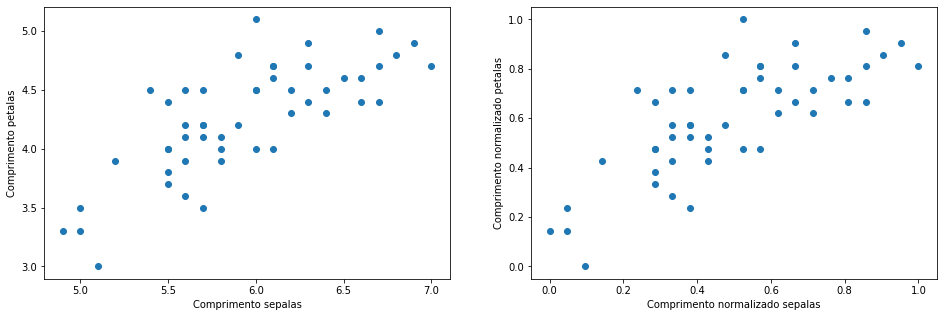

In [ ]:
x = x_in - x_in.min()
x /= x.max()    # normalização
y = y_in - y_in.min()
y /= y.max()

fig = plt.figure(figsize=(16,5))
ax_in = fig.add_subplot(1,2,1)
ax_in.scatter(x_in, y_in)
ax_in.set_xlabel('Comprimento sepalas')
ax_in.set_ylabel('Comprimento petalas')
ax_n = fig.add_subplot(1,2,2)
ax_n.scatter(x, y)
ax_n.set_xlabel('Comprimento normalizado sepalas')
ax_n.set_ylabel('Comprimento normalizado petalas');

## Reta de ajuste

A equação da reta no plano necessita de dois parâmetros, aqui denominados $w_0$ (*bias*) e inclinação $w_1$. Veja figura:


<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/linhareta.png" width="300pt">

A reta de ajuste será dada por:

$$ \hat{y} = w_0 + w_1 x $$

onde 
* $w_1$ é o coeficiente angular da reta e 
* $w_0$ é a interseção do eixo vertical quando x é igual a zero, também denominado de *bias*.
* $x$ é a variável de entrada (comprimento das sépalas) e 
* $\hat{y}$ é a predição (comprimento estimado das pétalas).

## Representação gráfica da equação linear via neurônio

$ \hat{y} = 1 w_0 + x_0 w_1 $

Temos:
- 1 atributo de entrada: $x_0$
- 2 parâmetros para serem ajustados (treinados) $w_0$ e $w_1$
- 1 classe de saída $\hat{y}$

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinearNeuronio.png" width="300pt">
$$ \hat{y} = w_0 + w_1 x $$
$$ \mathbf{\hat{y}} = \mathbf{w} \mathbf{x} $$

### Função Custo ou de Perda (MSE - Mean Square Error)

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master//figures/Loss_MSE.png" width = "600pt">


A função de custo depende do conjunto de treinamento ($y_i$) e dos valores de predição ($\hat{y_i}$):

$$ J(\hat{y_i},y_i) = \frac{1}{M} \sum_{i=0}^{M-1} (\hat{y_i} - y_i)^2 $$ .


## Laço de minimização via gradiente descendente

O código da próxima célula é a parte principal deste notebook. É aqui que a minimização é feita. É aqui que dizemos que estamos fazendo o *fit*, ou o treinamento do sistema para encontrar o parâmetro $\mathbf{W}$ que minimiza a função de perda $J$. Acompanhamos a convergência da minimização pelo valor da perda a cada iteração, plotando o vetor `J_history`.

O esquema da otimização é representado pelo diagrama a seguir:

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/RegressaoLinear_Otimizacao.png" width = "600pt">

e é implementado pela próxima célula de código:

## Funções: Custo, Gradiente Descendente

In [ ]:
# É importante fixar as seeds para passar nos asserts abaixo.
import torch
import random
import numpy as np
from torch import nn, optim

random.seed(123)
np.random.seed(123)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, n_in: int, n_out: int):
        # Escreva seu código aqui.
        # Não se esqueça de inicializar os pesos da rede com zeros.
        super(Model, self).__init__()
        self.linear = nn.Linear(n_in, n_out, bias=False)
        self.linear.weight.data.fill_(0.0)  #https://gist.github.com/ikhlestov/031e0f4e83b968cede8df1d19f3d4714
        #self.linear.bias.data.fill_(0.0) #https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
        
    def forward(self, x):
        # Escreva seu código aqui.
        y_pred = self.linear(x)
        return y_pred

In [ ]:
def train(model, x, y, learning_rate: float, n_epochs: int):
    """Train a linear model with SGD.
    Returns:
        loss_history: a np.array of shape (n_epochs,)
        w_history: a np.array of shape (n_epochs, 2)
    """
    # Escreva seu código aqui.
    x = torch.hstack((torch.ones((x.size(0), 1)), x)) 
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    loss_history = []
    w_history = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        # forward - predict
        out = model.forward(x)
        #loss cálculo da função de perda
        loss = criterion(out, y)
        loss.backward()
        # save
        loss_history.append(loss.item())
        w_history.append(model.linear.weight.data.reshape(2,).tolist()) 
        optimizer.step()

    w_history.append(model.linear.weight.data.reshape(2,).tolist())  
    return loss_history, np.array(w_history)

### Testando as funções

In [ ]:
model = Model(2, 1) # duas entradas (1 + x0) e uma saída y_pred
loss_history, w_history = train(model=model, x=x, y=y, learning_rate=0.5, n_epochs=20)

In [ ]:
# Assert de losses ao longo do treinamento
target_loss_history = np.array([0.40907028317451477, 0.05599689856171608, 0.0320851095020771, 0.029729025438427925, 
                                0.028852572664618492, 0.028139224275946617, 0.02749694138765335, 0.026914162561297417, 
                                0.026385080069303513, 0.025904731824994087, 0.02546861581504345, 0.025072669610381126, 
                                0.02471318654716015, 0.0243868138641119, 0.02409050054848194, 0.023821473121643066, 
                                0.023577222600579262, 0.02335546910762787, 0.023154139518737793, 0.022971350699663162])

assert np.allclose(loss_history, target_loss_history, atol=1e-6)

In [ ]:
# Assert de histórico de pesos da rede
target_w_history = np.array(
    [[0.,         0.        ],
    [0.6,        0.336644  ],
    [0.4339223,  0.27542454],
    [0.4641239,  0.31466085],
    [0.44476733, 0.3271254 ],
    [0.43861815, 0.3453676 ],
    [0.42961866, 0.3611236 ],
    [0.4218457,  0.37655178],
    [0.41423446, 0.3911463 ],
    [0.40703452, 0.4050796 ],
    [0.40016073, 0.41834888],
    [0.39361456, 0.43099412],
    [0.38737625, 0.44304258],
    [0.38143232, 0.4545229 ],
    [0.3757687,  0.4654618 ],
    [0.37037218, 0.4758848 ],
    [0.36523017, 0.48581624],
    [0.36033067, 0.49527928],
    [0.35566223, 0.50429606],
    [0.35121396, 0.5128876 ],
    [0.34697545, 0.52107394]])

assert np.allclose(w_history, target_w_history, atol=1e-6)

# Função de cálculo do grid de custos

In [ ]:
x = x.detach().numpy()
y = y.detach().numpy()

In [ ]:
def compute_loss_grid(x, y, w_0_grid, w_1_grid):
    """Returns:
        loss_grid: an array with the same shape of w_0_grid (or w_1_grid). 
    """
    # Escreva seu código aqui.
    w0, w1 = np.meshgrid(w_0_grid,w_1_grid) #https://interactivechaos.com/es/manual/tutorial-de-numpy/la-funcion-meshgrid
    lenght = w0.shape
    w0 = w0.reshape(1, -1)  #add dimenssion
    w1 = w1.reshape(1, -1)  #add dimenssion

    y_pred = w0 + w1 * x  # 
    loss = np.mean((y_pred - y)**2, axis=0) 
    lossg = loss.reshape(lenght) 
    return lossg

In [ ]:
wmin = w_history.min(axis=0)
wmax = w_history.max(axis=0)
D = wmax - wmin
wmin -= D
wmax += D

w_0_grid = np.linspace(wmin[0], wmax[0], 100)
w_1_grid = np.linspace(wmin[1], wmax[1], 100)

loss_grid = compute_loss_grid(x, y, w_0_grid, w_1_grid)

### Testando a função

In [ ]:
!gsutil cp gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy .
target_loss_grid = np.load('target_loss_grid.npy')

Copying gs://unicamp-dl/ia025a_2022s1/aula2/target_loss_grid.npy...
/ [1 files][ 78.2 KiB/ 78.2 KiB]                                                
Operation completed over 1 objects/78.2 KiB.                                     


In [ ]:
assert np.allclose(loss_grid, target_loss_grid, atol=1e-6) 

## Funcão de Plot

In [ ]:
def show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.3):
    n_samples = y.shape[0]

    # valor ótimo, solução analítica
    # ------------------------------
    x_bias = np.hstack([np.ones((n_samples, 1)), x])
    w_opt = (np.linalg.inv((x_bias.T).dot(x_bias)).dot(x_bias.T)).dot(y)    
    x_all = np.linspace(x.min(), x.max(), 100).reshape(100, 1)
    x_all_bias = np.hstack([np.ones((100, 1)), x_all])
    result_opt = x_all_bias.dot(w_opt)    # Predição do valor ótimo
        
    # Gráficos:
    # --------
    fig = plt.figure(figsize=(18, 6))
    ax_grid = fig.add_subplot(1, 3, 1)    # Grid de losses
    ax_loss = fig.add_subplot(1, 3, 2)    # Função perda

    ax_loss.plot(loss_history)
    ax_loss.set_title('Perda', fontsize=15)
    ax_loss.set_xlabel('epochs', fontsize=10)
    ax_loss.set_ylabel('MSE', fontsize=10)

    ax_grid.pcolormesh(w_0_grid, w_1_grid, loss_grid, cmap=plt.cm.coolwarm)
    ax_grid.contour(w_0_grid, w_1_grid, loss_grid, 20)
    ax_grid.scatter(w_opt[0], w_opt[1], marker='x', c='w')  # Solução analítica.
    ax_grid.set_title('W', fontsize=15)
    ax_grid.set_xlabel('w0', fontsize=10)
    ax_grid.set_ylabel('w1', fontsize=10)

    # Plot dinâmico
    # -------------
    for i, (loss, w) in enumerate(zip(loss_history, w_history)):
        ax_loss.scatter(i, loss)
                            
        ax_grid.scatter(w[0], w[1], c='r', marker='o')
        
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(sleep)


## Plotagem iterativa do gradiente descendente, reta ajuste, parâmetros, função perda

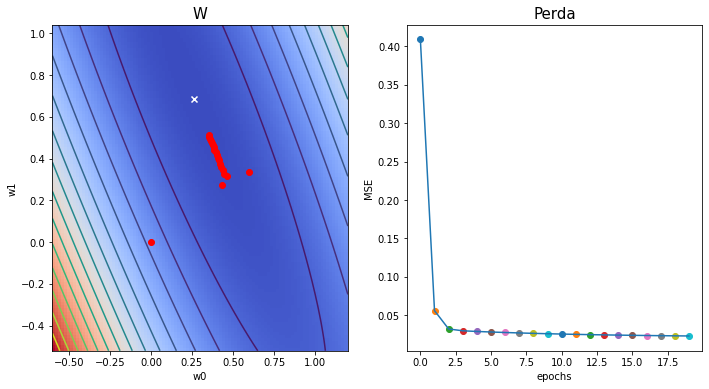

In [ ]:
%matplotlib inline
try:
    show_plots(x, y, w_0_grid, w_1_grid, loss_grid, loss_history, w_history, sleep=0.01)
except KeyboardInterrupt:
    pass